In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing important libraries

In [53]:
%matplotlib inline
import pandas as pd
import json
import csv
import matplotlib as fig
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import math, nltk, warnings
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import wordnet
import warnings; warnings.simplefilter('ignore')

In [54]:
from sklearn import linear_model
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
from wordcloud import WordCloud, STOPWORDS
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
warnings.filterwarnings('ignore')


# Data Cleaning

In [55]:
import nltk
from nltk import *
from nltk.corpus import wordnet
!pip install wordnet
from nltk.stem import PorterStemmer
PS = nltk.stem.PorterStemmer()
nltk.download('wordnet', '/usr/share/nltk_data')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [56]:
#Fucntion to count the occurence 
def word_quantity(data, reference, listing):
    kw_number = dict()
    for s in listing: kw_number[s] = 0
    for listing_kw in data[reference].str.split('|'):        
        if type(listing_kw) == float and pd.isnull(listing_kw): continue        
        for s in [s for s in listing_kw if s in listing]: 
            if pd.notnull(s): kw_number[s] += 1
    keyword_numbers = []
    for k,v in kw_number.items():
        keyword_numbers.append([k,v])
    keyword_numbers.sort(key = lambda x:x[1], reverse = True)
    return keyword_numbers, kw_number

Now we import the the dataset formed at the end of the exploratory dataset analysis notebook.

In [57]:
df_clean = pd.read_csv("/content/drive/MyDrive/full-movie-dataset.csv")

In [58]:
#We now group keywords with similar roots into one category

def keywords_formatting(data, col = 'keywords'):
    PS = nltk.stem.PorterStemmer()
    roots  = dict()   
    selected = dict()  #associations of keywords roots to a category
    category = []
    count = 0
    for s in data[col]:
        if pd.isnull(s): continue
        for word in s.split('|'):
            word = word.lower() ; r = PS.stem(word)
            if r in roots:                
                roots[r].add(word)
            else:
                roots[r] = {word}
    
    for s in roots.keys():
        if len(roots[s]) > 1:  
            min_length = 1000
            for k in roots[s]:
                if len(k) < min_length:
                    cat = k ; min_length = len(k)            
            category.append(cat)
            selected[s] = cat
        else:
            category.append(list(roots[s])[0])
            selected[s] = list(roots[s])[0]
                   
    print("Number of keywords in variable '{}': {}".format(col,len(category)))
    return category, roots, selected

In [59]:
keywords, roots, selected = keywords_formatting(df_clean, col = 'keywords')

Number of keywords in variable 'keywords': 9473


In [60]:
# Plot of similar keywords
count = 0
for s in roots.keys():
    if len(roots[s]) > 1: 
        count += 1
        if count < 15: print(count, roots[s], len(roots[s]))

1 {'alien', 'alienation'} 2
2 {'spy', 'spying'} 2
3 {'vigilante', 'vigilantism'} 2
4 {'terrorism', 'terror'} 2
5 {'flooding', 'flood'} 2
6 {'spiders', 'spider'} 2
7 {'horses', 'horse'} 2
8 {'musical', 'music'} 2
9 {'animation', 'animal', 'anime'} 3
10 {'compassion', 'compass'} 2
11 {'train', 'training'} 2
12 {'sailing', 'sail'} 2
13 {'time travel', 'time traveler'} 2
14 {'orc', 'orcs'} 2


In [61]:
#Replace the keywords with same roots by one main keyword. 

def replace_keywords(df, association, roots = False):
    df_new = df.copy(deep = True)
    for index, row in df_new.iterrows():
        kwords = row['keywords']
        if pd.isnull(kwords): continue
        new_keywords = []
        for s in kwords.split('|'): 
            t = PS.stem(s) if roots else s
            if t in association.keys():
               new_keywords.append(association[t])
            else:
               new_keywords.append(s)       
        df_new.at[index, 'keywords'] = '|'.join(map(str, new_keywords)) 
    return df_new

In [62]:
df_keywords_cleaned = replace_keywords(df_clean, selected, roots = True)

In [63]:
keyword_numbers, keywords_count = word_quantity(df_clean,'keywords',keywords)
keyword_numbers[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 189]]

Group by synonyms

We replace keywords occuring less than five times with a synonym

In [64]:
#we get synonymes of words from wordnet using synsets

def get_synonymes(word):
    synonyms = set()
    for s in wordnet.synsets(word):
        for w in s.lemma_names():
           
            index = s.name().find('.')+1
            if s.name()[index] == 'n': synonyms.add(w.lower().replace('_',' '))
    return synonyms

In [65]:
# Example of a list of synonyms given by NLTK

word = 'fight'
synonyms = get_synonymes(word)
for s in synonyms:
    print(' "{:<20}" in keywords list -> {} {}'.format(s, s in keywords,
                                                keywords_count[s] if s in keywords else 0 ))

 "fighting            " in keywords list -> False 0
 "competitiveness     " in keywords list -> False 0
 "engagement          " in keywords list -> False 0
 "battle              " in keywords list -> True 31
 "fight               " in keywords list -> True 47
 "scrap               " in keywords list -> False 0
 "combat              " in keywords list -> True 10
 "conflict            " in keywords list -> True 1


In [66]:
# check if 'word' is a key of 'key_count' with a test on the number of occurences   

def test_keyword(word, key_count, threshold):
    return (False , True)[key_count.get(word, 0) >= threshold]

In [67]:
# Now we replace keywords with higher frequency words

keyword_numbers.sort(key = lambda x:x[1], reverse = False)
key_count = dict()
for s in keyword_numbers:
    key_count[s[0]] = s[1]

replacement_word = dict()
count = 0
for index, [word, nb_apparitions] in enumerate(keyword_numbers):
    if nb_apparitions > 5: continue  # only the keywords that appear less than 5 times
    synonym = get_synonymes(word)
    if len(synonym) == 0: continue     # case of the plurals
    #_________________________________________________________________
    list_word = [(s, key_count[s]) for s in synonym 
                  if test_keyword(s, key_count, key_count[word])]
    list_word.sort(key = lambda x:(x[1],x[0]), reverse = True)    
    if len(list_word) <= 1: continue       # no replacement
    if word == list_word[0][0]: continue    # replacement by himself
    count += 1
    if  count < 8:
        print('{:<12} -> {:<12} (init: {})'.format(word, list_word[0][0], list_word))    
    replacement_word[word] = list_word[0][0]

print(90*'_'+'\n'+'The replacement concerns {}% of the keywords.'
      .format(round(len(replacement_word)/len(keywords)*100,2)))

narcism      -> narcissism   (init: [('narcissism', 1), ('narcism', 1)])
apparition   -> phantom      (init: [('phantom', 3), ('shadow', 1), ('apparition', 1)])
sail         -> cruise       (init: [('cruise', 3), ('sail', 1)])
macao        -> macau        (init: [('macau', 1), ('macao', 1)])
universe     -> existence    (init: [('existence', 2), ('world', 1), ('universe', 1), ('creation', 1)])
regent       -> trustee      (init: [('trustee', 1), ('regent', 1)])
human        -> human being  (init: [('human being', 5), ('human', 1)])
__________________________________________________________________________________________
The replacement concerns 6.09% of the keywords.


In [68]:
print('Keywords that appear both in keys and values:'.upper()+'\n'+45*'-')
count = 0
for s in replacement_word.values():
    if s in replacement_word.keys():
        count += 1
        if count < 10: print('{:<20} -> {:<20}'.format(s, replacement_word[s]))

for key, value in replacement_word.items():
    if value in replacement_word.keys():
        replacement_word[key] = replacement_word[value] 

KEYWORDS THAT APPEAR BOTH IN KEYS AND VALUES:
---------------------------------------------
failure              -> loser               
leech                -> parasite            
office               -> power               
office               -> power               
carnival             -> circus              
pit                  -> hell                
drawing              -> lottery             
twist                -> crook               
pest                 -> plague              


In [69]:
# replacement of keyword varieties by the main keyword

df_keywords_synonyms = replace_keywords(df_keywords_cleaned, replacement_word, roots = False)   
kw, keywords_roots, keywords_select = keywords_formatting(df_keywords_synonyms, col = 'keywords')

Number of keywords in variable 'keywords': 8899


In [70]:
new_keyword_numbers, keywords_count = word_quantity(df_keywords_synonyms,
                                                    'keywords',keywords)
new_keyword_numbers[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 197]]

In [71]:
def delete_low_fq(df, keyword_numbers):
    df_new = df.copy(deep = True)
    key_count = dict()
    for s in keyword_numbers: 
        key_count[s[0]] = s[1]    
    for index, row in df_new.iterrows():
        kwords = row['keywords']
        if pd.isnull(kwords): continue
        new_keywords = []
        for s in kwords.split('|'): 
            if key_count.get(s, 4) > 3: new_keywords.append(s)
        df_new.at[index, 'keywords'] = '|'.join(map(str, new_keywords))
    return df_new

In [72]:
# Creation of a dataframe where keywords of low frequencies are suppressed

df_keywords_occurence = delete_low_fq(df_keywords_synonyms, new_keyword_numbers)
keywords, roots, selected = keywords_formatting(df_keywords_occurence, col = 'keywords') 

Number of keywords in variable 'keywords': 2109


In [73]:
keywords.remove('')
new_keyword_numbers, keywords_count = word_quantity(df_keywords_occurence,
                                                    'keywords',keywords)
new_keyword_numbers[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 197]]

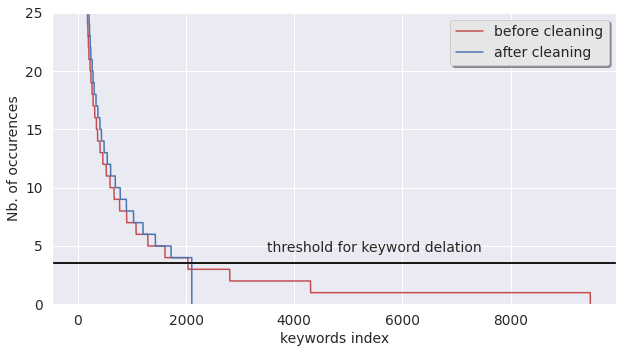

In [88]:
# Graph of keyword occurences before and after cleaning

font = {'family' : 'ariel', 'weight' : 'normal', 'size'   : 14}
mpl.rc('font', **font)

keyword_numbers.sort(key = lambda x:x[1], reverse = True)

y_axis = [i[1] for i in keyword_numbers]
x_axis = [k for k,i in enumerate(keyword_numbers)]

new_y_axis = [i[1] for i in new_keyword_numbers]
new_x_axis = [k for k,i in enumerate(new_keyword_numbers)]

f, ax = plt.subplots(figsize=(9, 5))
ax.plot(x_axis, y_axis, 'r-', label='before cleaning')
ax.plot(new_x_axis, new_y_axis, 'b-', label='after cleaning')

# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('medium')
            
plt.ylim((0,25))
plt.axhline(y=3.5, linewidth=2, color = 'k')
plt.xlabel("keywords index", family='DejaVu Sans', fontsize = 14)
plt.ylabel("Nb. of occurences", family='DejaVu Sans', fontsize = 14)
plt.text(3500, 4.5, 'threshold for keyword delation', fontsize = 14)
plt.show()

In [75]:
df_var_cleaned = df_keywords_occurence.copy(deep = True)

We examine the number of missong values in the data and then use different methods to fill in 

In [76]:
df_filling = df_var_cleaned.copy(deep=True)
missing_year_info = df_filling[df_filling['title_year'].isnull()][[
            'director_name','actor_1_name', 'actor_2_name', 'actor_3_name']]
missing_year_info[:10]

,director_name,actor_1_name,actor_2_name,actor_3_name
4553,NaN,NaN,NaN,NaN


In [77]:
df_filling.iloc[4553]

Unnamed: 0                                                           4553
budget                                                                  0
genres                                                                NaN
homepage                                                              NaN
id                                                                 380097
keywords                                                              NaN
language                                                              NaN
original_title                                 America Is Still the Place
overview                1971 post civil rights San Francisco seemed li...
popularity                                                            0.0
production_companies                                                   []
production_countries                                                   []
release_date                                                          NaN
revenue                               

In [78]:
def fill_year(df):
    col = ['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name']
    usual_year = [0 for _ in range(4)]
    var        = [0 for _ in range(4)]
    
    for i in range(4):
        usual_year[i] = df.groupby(col[i])['title_year'].mean()
    
    actor_year = dict()
    for i in range(4):
        for s in usual_year[i].index:
            if s in actor_year.keys():
                if pd.notnull(usual_year[i][s]) and pd.notnull(actor_year[s]):
                    actor_year[s] = (actor_year[s] + usual_year[i][s])/2
                elif pd.isnull(actor_year[s]):
                    actor_year[s] = usual_year[i][s]
            else:
                actor_year[s] = usual_year[i][s]
        
   
    missing_year_info = df[df['title_year'].isnull()]
   
    count_replaced = 0
    for index, row in missing_year_info.iterrows():
        value = [ np.NaN for _ in range(4)]
        count = 0 ; sum_year = 0
        for i in range(4):            
            var[i] = df.loc[index][col[i]]
            if pd.notnull(var[i]): value[i] = actor_year[var[i]]
            if pd.notnull(value[i]): count += 1 ; sum_year += actor_year[var[i]]
        if count != 0: sum_year = sum_year / count 

        if int(sum_year) > 0:
            count_replaced += 1
            df.set_value(index, 'title_year', int(sum_year))
            if count_replaced < 10: 
              print("{:<45} -> {:<20}".format(df.loc[index]['movie_title'],int(sum_year)))
    return 

In [79]:
fill_year(df_filling)

In [80]:
# Extracting keywords from the title

count = 0
for index, row in df_filling[df_filling['keywords'].isnull()].iterrows():
    count += 1
    word_list = row['title'].strip().split()
    new_keyword = []
    for s in word_list:
        synonym = get_synonymes(s)
        for t in list(synonym):
            if t in keywords: 
                new_keyword.append(t)                
    if new_keyword and count < 15: 
        print('{:<50} -> {:<30}'.format(row['title'], str(new_keyword)))
    if new_keyword:
        df_filling.at[index, 'keywords'] = '|'.join(map(str, new_keyword)) 

The Mummy: Tomb of the Dragon Emperor              -> ['grave', 'dragon', 'emperor']
The Lovers                                         -> ['lover']                     
Sex and the City 2                                 -> ['sexuality', 'sex', 'city']  
The Nutcracker: The Untold Story                   -> ['history', 'narration']      
Legends of Oz: Dorothy's Return                    -> ['legend', 'return']          
Dragon Blade                                       -> ['dragon', 'sword']           
Bullet to the Head                                 -> ['chief']                     
Beloved                                            -> ['love']                      
Hereafter                                          -> ['afterlife', 'future']       
Man of the House                                   -> ['human being', 'family', 'house']


Imputing from regression

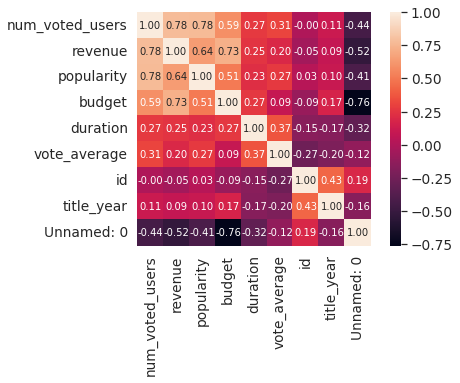

In [81]:
corrmat = df_keywords_occurence.dropna(how='any').corr()
cols = corrmat.nlargest(9, 'num_voted_users')['num_voted_users'].index
cm = np.corrcoef(df_keywords_occurence[cols].dropna(how='any').values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

We will fill variables like gross, num_critic_for_reviews, num_voted_users , and num_user_for_reviews using regression as they have some degree of correleation.

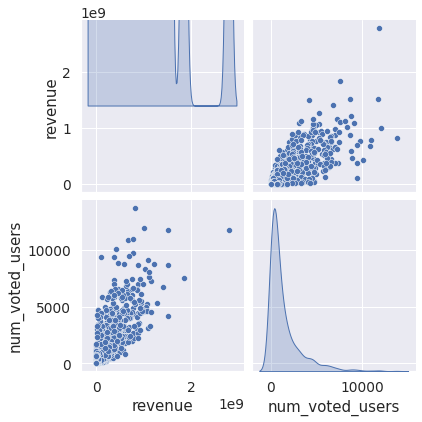

In [82]:
# showing the relation between revenue and num_voted_users

sns.set(font_scale=1.25)
cols = ['revenue', 'num_voted_users']
sns.pairplot(df_filling.dropna(how='any')[cols],diag_kind='kde', size = 3)
plt.show();

In [83]:
def linear_reg(df, col_to_predict, ref_col):
    regression = linear_model.LinearRegression()
    test = df[[col_to_predict,ref_col]].dropna(how='any', axis = 0)
    X = np.array(test[ref_col])
    Y = np.array(test[col_to_predict])
    X = X.reshape(len(X),1)
    Y = Y.reshape(len(Y),1)
    regression.fit(X, Y)
    
    test = df[df[col_to_predict].isnull() & df[ref_col].notnull()]
    for index, row in test.iterrows():
        value = float(regression.predict(row[ref_col]))
        df.set_value(index, col_to_predict, value)

In [84]:
linear_reg(df_filling, 'revenue', 'num_voted_users')

In [85]:
df = df_filling.copy(deep = True)
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['filling_factor'] = (df.shape[0] 
                                - missing_df['missing_count']) / df.shape[0] * 100
missing_df = missing_df.sort_values('filling_factor').reset_index(drop = True)
missing_df

,column_name,missing_count,filling_factor
0,homepage,3091,35.644389
1,tagline,844,82.427649
2,keywords,186,96.127420
3,country,174,96.377264
4,language,98,97.959609
5,actor_3_name,93,98.063710
6,actor_2_name,63,98.688320
7,actor_1_name,53,98.896523
8,director_name,30,99.375390
9,genres,28,99.417031


In [86]:
df = df_filling.copy(deep=True)
df.reset_index(inplace = True, drop = True)
df.to_csv('clean_data.csv')